<a href="https://colab.research.google.com/github/AmrMomtaz/Reviews-Classification/blob/main/Bert_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Movies reviews classification using BERT**

## Problem Statement

IMDB is the most globally famous movie reviews website where you can publish a review for
any film you watched. Classifying the positive reviews and the negative ones can be useful for
several purposes such as giving an overall rating for the film or making statistical analysis about
the preferences of people from different countries, age levels, etc... So IMDB dataset is released
which composed of 50k reviews labeled as positive or negative to enable training movie reviews
classifiers. Moreover, NLP tasks are currently solved based on pretrained language models such
as BERT. These models provide a deep understanding of both semantic and contextual aspects
of language words, sentences or even large paragraphs due to their training on huge corpus for
very long time. In this notebook We will download the IMDB dataset from kaggle using this <a href = "https://www.kaggle.com/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews">
Link</a>. Then, we will train BERT based classifier for movie reviews.


I'm going to use split the data 70% training and 10% dev and 20% for testing.
We will use BERT pretrained weights first and we will and we will use early stopping using 3 steps

## Installation

In this section we are going to get the problem data and install required libraries.
First you have to **upload** the kaggle API token to the current running sesion then run the following cells.

In [ ]:
# Cloning Data 
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! kaggle datasets download -d lakshmi25npathi/imdb-dataset-of-50k-movie-reviews
! unzip /content/imdb-dataset-of-50k-movie-reviews.zip
! rm /content/imdb-dataset-of-50k-movie-reviews.zip
! pip install transformers

# Importing libraries
# For EDA and data cleaning
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
# For preprocessing the data
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re
# For creating the dataset and the bert model
import torch
from torch import nn
from transformers import BertTokenizer
from transformers import BertModel
from torch.optim import Adam
from tqdm import tqdm

 39% 10.0M/25.7M [00:00<00:00, 104MB/s]
100% 25.7M/25.7M [00:00<00:00, 126MB/s]
Archive:  /content/imdb-dataset-of-50k-movie-reviews.zip
  inflating: IMDB Dataset.csv        
     |████████████████████████████████| 3.5 MB 5.8 MB/s 
     |████████████████████████████████| 6.8 MB 19.3 MB/s 
     |████████████████████████████████| 596 kB 36.9 MB/s 
     |████████████████████████████████| 895 kB 43.5 MB/s 
     |████████████████████████████████| 67 kB 2.4 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


## EDA and cleaning the data
In this section we are going to do some EDA for better insight of the data

In [ ]:
# Creating dataframe and changing the lables to categorical
df = pd.read_csv('IMDB Dataset.csv')
print(f"Data frame shape = {df.shape}")
print(f"Dataframe description: \n{df.describe()}")
print(f"Dataframe duplicated rows: {sum(df.duplicated())}")
df.head()

Data frame shape = (50000, 2)
Dataframe description: 
                                                   review sentiment
count                                               50000     50000
unique                                              49582         2
top     Loved today's show!!! It was a variety and not...  positive
freq                                                    5     25000
Dataframe duplicated rows: 418


,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


We will drop the duplicated rows and we will see the number of positive and negative examples to see if under-sampling or over-sampling is required and we will change the categorical column ("sentiment") to zeros and ones and change its name to label

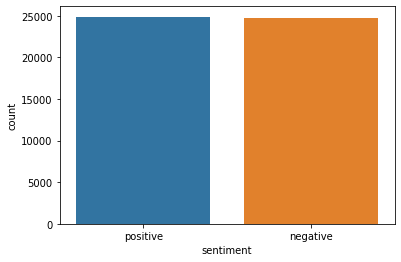

In [ ]:
# Droping the duplicated rows
df.drop_duplicates(inplace = True)
# Plotting the sentiment column
sb.countplot(x='sentiment', data=df)
# Modifying the sentiment column
df["sentiment"] = df["sentiment"].astype('category')
df["label"] = df["sentiment"].cat.codes
df = df.drop(columns=['sentiment'])

As we can see there is no need for under sampling or over sampling since the the data is balanced for both classes

## Data Pre-processing and splitting

Run the following cell to pre-process the data. In the data pre-processing there are four things to be done:
* Remove punctuations
* Remove stop words
* Lower case all words
* Lemmatization of words

In [ ]:
# Lowercase all characters
df["review"] = df.review.apply(lambda x : str.lower(x))

# Removing punctiations and <br />
df["review"] = df.review.apply(lambda x : " ".join(re.findall('[\w]+',x)))
df["review"] = df.review.apply(lambda x : x.replace('br', ''))

# Removing stop words
stop_words = set(stopwords.words('english'))
df["review"] = df.review.apply(
    lambda x : ' '.join(word for word in x.split() if word not in stop_words))
df["review"] = df.review.apply(lambda x : x.replace('   ', ' '))

# Lemmatization
w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()
def lemmatize_text(text):
    return [lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(text)]

df["review"] = df.review.apply(lambda x : lemmatize_text(x))
df.head()

Now we will dplit the data to 70% train ,10% dev and 20% test and we will stratify and resample it to be randomly ordered

In [ ]:
# Stratify and split
train_list = []
test_list = []
val_list = []
grouped_df = df.groupby('labels')

for i, g in grouped_df:
    train, val, test = np.split(g, [int(.7 * len(g)), int(.8 * len(g))])
    train_list.append(train); test_list.append(test); val_list.append(val)

df_train = pd.concat(train_list)
df_val = pd.concat(val_list)
df_test = pd.concat(test_list)
# Resampling
df_train = df_train.sample(frac = 1)
df_val = df_val.sample(frac = 1)
df_test = df_test.sample(frac = 1)

## Building Dataset and Model

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
class Dataset(torch.utils.data.Dataset):

    def __init__(self, df):

        self.labels = list(df.labels)
        self.texts = list(df.review.apply(lambda x :tokenizer(x, 
                               padding='max_length', max_length = 512, truncation=True,
                                return_tensors="pt")))

    def classes(self):
        return self.labels

    def __len__(self):
        return len(self.labels)

    def get_batch_labels(self, idx):
        # Fetch a batch of labels
        return np.array(self.labels[idx])

    def get_batch_texts(self, idx):
        # Fetch a batch of inputs
        return self.texts[idx]

    def __getitem__(self, idx):

        batch_texts = self.get_batch_texts(idx)
        batch_y = self.get_batch_labels(idx)

        return batch_texts, batch_y

In [ ]:
class BertClassifier(nn.Module):

    def __init__(self):

        super(BertClassifier, self).__init__()

        self.bert = BertModel.from_pretrained('bert-base-cased')
        self.dropout_bert = nn.Dropout(0.5)
        self.dropout = nn.Dropout(0.2)
        self.linear1 = nn.Linear(768, 512)
        self.batchnorm1 = nn.BatchNorm1d(512)
        self.linear2 = nn.Linear(512, 256)
        self.batchnorm2 = nn.BatchNorm1d(256)
        self.linear3 = nn.Linear(256, 128)
        self.linear4 = nn.Linear(128, 64)
        self.linear_out = nn.Linear(64, 1)
        self.relu1 = nn.ReLU()
        self.relu2 = nn.ReLU()
        self.relu3 = nn.ReLU()
        self.relu4 = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, input_id, mask):

        _, x = self.bert(input_ids=input_id, attention_mask=mask,return_dict=False)
        x = self.dropout_bert(x)
        x = self.relu1(self.linear1(x))
        x = self.batchnorm1(x)
        x = self.relu2(self.linear2(x))
        x = self.batchnorm2(x)
        x = self.relu3(self.linear3(x))
        x = self.dropout(x)
        x = self.relu4(self.linear4(x))
        x = self.dropout(x)
        x = self.sigmoid(self.linear_out(x))
        return x

## Training and testing the model

In [ ]:
train_loss = list()
val_loss = list()
train_accuracy = list()
val_accuracy = list()

def train(model, train_data, val_data, learning_rate, epochs):

    train, val = Dataset(train_data), Dataset(val_data)

    train_dataloader = torch.utils.data.DataLoader(train, batch_size=64, shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(val, batch_size=2)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    criterion = nn.BCELoss()
    optimizer = Adam(model.parameters(), lr= learning_rate, weight_decay=1e-5)

    if use_cuda:

            model = model.cuda()
            criterion = criterion.cuda()

    for epoch_num in range(epochs):

            total_acc_train = 0
            total_loss_train = 0

            for train_input, train_label in tqdm(train_dataloader):

                train_label = train_label.to(device)
                mask = train_input['attention_mask'].to(device)
                input_id = train_input['input_ids'].squeeze(1).to(device)
                output = model(input_id, mask)

                batch_loss = criterion(output.squeeze(1), train_label.float())
                total_loss_train += batch_loss.item()

                y_pred_tag = torch.round(output.squeeze(1))
                acc = (y_pred_tag == train_label).sum()

                total_acc_train += acc

                model.zero_grad()
                batch_loss.backward()
                optimizer.step()
            
            total_acc_val = 0
            total_loss_val = 0

            with torch.no_grad():

                for val_input, val_label in val_dataloader:

                    val_label = val_label.to(device)
                    mask = val_input['attention_mask'].to(device)
                    input_id = val_input['input_ids'].squeeze(1).to(device)

                    output = model(input_id, mask)

                    batch_loss = criterion(output.squeeze(1), val_label.float())
                    total_loss_val += batch_loss.item()
                    
                    y_pred_tag = torch.round(output.squeeze(1))
                    acc = (y_pred_tag == val_label).sum()
                    total_acc_val += acc
            
            train_loss.append(total_loss_train / len(train_data))
            train_accuracy.append(total_acc_train / len(train_data))
            val_loss.append(total_loss_val / len(val_data))
            val_accuracy.append(total_acc_val / len(val_data))

            print(
                f'Epochs: {epoch_num + 1} | Train Loss: {total_loss_train / len(train_data): .3f} \
                | Train Accuracy: {total_acc_train / len(train_data): .3f} \
                | Val Loss: {total_loss_val / len(val_data): .3f} \
                | Val Accuracy: {total_acc_val / len(val_data): .3f}')
            
            
                  
EPOCHS = 5
model = BertClassifier()
LR = 1e-5

train(model, df_train, df_val, LR, EPOCHS)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 32/32 [00:38<00:00,  1.20s/it]


Epochs: 1 | Train Loss:  0.021                 | Train Accuracy:  0.818                 | Val Loss:  0.322                 | Val Accuracy:  0.840


100%|██████████| 32/32 [00:38<00:00,  1.20s/it]


Epochs: 2 | Train Loss:  0.020                 | Train Accuracy:  0.846                 | Val Loss:  0.317                 | Val Accuracy:  0.865


100%|██████████| 32/32 [00:38<00:00,  1.20s/it]


Epochs: 3 | Train Loss:  0.020                 | Train Accuracy:  0.905                 | Val Loss:  0.309                 | Val Accuracy:  0.935


100%|██████████| 32/32 [00:38<00:00,  1.20s/it]


Epochs: 4 | Train Loss:  0.019                 | Train Accuracy:  0.925                 | Val Loss:  0.306                 | Val Accuracy:  0.935


100%|██████████| 32/32 [00:38<00:00,  1.20s/it]


Epochs: 5 | Train Loss:  0.019                 | Train Accuracy:  0.965                 | Val Loss:  0.298                 | Val Accuracy:  0.955


Plotting the model train and validation loss and accuracy

In [ ]:
plt.figure(figsize = [18, 5])
plt.suptitle("Loss and Accuracy in training")

plt.subplot(1,2,1)
plt.plot(epoch_list,train_loss);
plt.plot(epoch_list,val_loss);
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Train","Validation"])
plt.subplot(1,2,2)
plt.plot(epoch_list,train_accuracy);
plt.plot(epoch_list,val_accuracy);
plt.xlabel("Epochs");
plt.ylabel("Accuracy")
plt.legend(["Train","Validation"]);

Testing the model

In [ ]:
def evaluate(model, test_data):

    test = Dataset(test_data)

    test_dataloader = torch.utils.data.DataLoader(test, batch_size=32)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")
    final_confusion_matrix = np.zeros([2,2])

    if use_cuda:

        model = model.cuda()

    total_acc_test = 0
    
    with torch.no_grad():

        for test_input, test_label in test_dataloader:

              test_label = test_label.to(device)
              mask = test_input['attention_mask'].to(device)
              input_id = test_input['input_ids'].squeeze(1).to(device)
              output = model(input_id, mask)
              y_pred_tag = torch.round(output.squeeze(1))
              acc = (y_pred_tag == test_label).sum()
              total_acc_test += acc
              final_confusion_matrix += confusion_matrix(test_label.cpu().data.numpy(), y_pred_tag.cpu().data.numpy())
    
    TP = final_confusion_matrix[0][0]
    FP = final_confusion_matrix[0][1]
    FN = final_confusion_matrix[1][0]
    TN = final_confusion_matrix[1][1]
    Percision = TP/(TP+FP)
    Recall = TP/(TP+FN)
    print(f'Test Accuracy: {total_acc_test / len(test_data): .3f}')
    print(f'Percision : {Percision}')
    print(f'Sensitivity (Recall) : {Recall}')
    print(f'Specifity : {TN/(TN+FP)}')
    print(f'F1 Score = {((2*Percision*Recall)/(Percision+Recall))}')
    print('Confusion Matrix :')
    print(final_confusion_matrix)
    
evaluate(model, df_test)